In [262]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Spectral")
sns.set_style()

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks

In [310]:
import keras
import tensorflow as tf
import tensorflow.keras.layers as KL

In [365]:
def plotloss(history_dict, loss='loss', val_loss='val_loss', fileName=""):
    '''
    See helpers documentation from 'Michael Telahun: Exploring Information for Quantum Assisted Learning'
    '''    
    loss_values = history_dict[loss]
    val_loss_values = history_dict[val_loss]
    epochs = range(1, len(loss_values) + 1)
    
    plt.figure(figsize=(12,8))
    plt.plot(epochs, loss_values, 'r', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    
#     fh.SaveFigure(plt, fileName + "-Loss")
    
def plotacc(history, acc='acc', val_acc='val_acc', fileName=""):
    '''
    See helpers documentation from 'Michael Telahun: Exploring Information for Quantum Assisted Learning'
    '''
    acc = history[acc]
    val_acc = history[val_acc]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,8))
    plt.plot(epochs, acc, 'r', label='Training Acc')
    plt.plot(epochs, val_acc, 'g', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

#     fh.SaveFigure(plt, fileName + "-Accuracy")

def plot_confusion_matrix(cm, classes, fileName="",
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BrBG):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#     fh.SaveFigure(plt, fileName + "-CNF_Matrix")
    
def Metriks_Multi(model, history, x_test, y_test, thresh=99, class_names=[0,1], loss='loss', val_loss='val_loss', acc='acc', val_acc='val_acc', fileName=""):
    '''
    See helpers documentation from 'Michael Telahun: Exploring Information for Quantum Assisted Learning'
    '''
    sns.set_style('dark')
    history_dict = history
    # history_dict.keys()

    evalulation = model.evaluate(x_test, y_test)
    
    for i, ele in enumerate(evalulation):
        print("Model Evaluation:", str(model.metrics_names[i]) + " ~ %.2f%%" % (ele * 100.0))
    ## force to binary behavior
    y_pred_ = []
    y_pred = model.predict(x_test)
    if thresh != 99:
        y_pred[y_pred < thresh] = class_names[0]
        y_pred[y_pred >= thresh] = class_names[1]
        y_pred_ = y_pred
    else:
        for i in range(0,len(y_pred)):
            y_pred_.append(np.argmax(y_pred[i]))
    print("-"*90)
    print(classification_report(y_test, y_pred))
    print("-"*90)
    
    accuracy = accuracy_score(y_test, y_pred_)
    # print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
    cnf_matrix = confusion_matrix(y_test, y_pred_, labels=class_names)
    
    plotloss(history_dict, loss, val_loss, fileName=fileName)
    plotacc(history_dict, acc, val_acc, fileName=fileName)
    
    plt.rcdefaults()
    plot_confusion_matrix(cnf_matrix, classes=list(map(str, class_names)), title='Confusion matrix', fileName=fileName)
    

    return [model.metrics_names, evalulation, y_pred_, classification_report(y_test, y_pred, output_dict=True), cnf_matrix]


def SimpleMLP(train=[], val=[], dropout=0.15, neuronsPerLayer=[256, 128, 64, 64], EPOCHS=1, BATCH_SIZE=2):
    '''
    See helpers documentation from 'Michael Telahun: Exploring Information for Quantum Assisted Learning'
    '''    
    assert (len(train) == 2), "Need x and y for train: [x_train, y_train]"
    assert (len(val) == 2), "Need x and y for val: [x_val, y_val]"
    inshape = train[0].shape
    model = tf.keras.Sequential()
    model.add(KL.Dense(neuronsPerLayer[0], input_shape=(7,)))
    model.add(KL.Dropout(dropout))
    model.add(KL.Dense(neuronsPerLayer[1]))
    model.add(KL.Dropout(dropout))
    model.add(KL.Dense(neuronsPerLayer[2]))
    model.add(KL.Dropout(dropout))
    model.add(KL.Dense(neuronsPerLayer[3]))
    model.add(KL.Dense(1, activation='relu'))
    
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),#rmsprop
            loss='mse',
            metrics='accuracy')
    
    history = model.fit(train[0],
                    train[1],
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val[0], val[1]))
    return model, history

In [17]:
def plotDf(df, layOut=(4,4)):
    df.plot(kind='line', subplots=True, layout=layOut, figsize=(22,50))
    plt.show()
    
def normalize(a):
    return (a-a.min())/(a.max()-a.min())

In [18]:
df = pd.read_csv("training.csv")

In [44]:
dfddos = df[df["Label"]=="ddos"]
dfbenign = df[df["Label"]=="Benign"]

In [45]:
dfddos.Label.value_counts(), dfbenign.Label.value_counts()

(ddos    129152
 Name: Label, dtype: int64,
 Benign    631275
 Name: Label, dtype: int64)

In [46]:
dfddos = dfddos.sample(frac=1, random_state=42).reset_index(drop=True)

In [47]:
dfbenign = dfbenign.sample(n=129152, random_state=42).reset_index(drop=True)

In [48]:
dfddos.Label.value_counts(), dfbenign.Label.value_counts()

(ddos    129152
 Name: Label, dtype: int64,
 Benign    129152
 Name: Label, dtype: int64)

In [50]:
df2 = dfddos.append(dfbenign)

In [51]:
len(dfddos)

129152

In [158]:
## maybes = ['Flow Duration', 'Down/Up Ratio']
empties1 = [
    'Down/Up Ratio',
    'Src Port', 'Dst Port', 'Protocol', ## cant include because synthetic and not meaningful
    'Unnamed: 0', 'Flow ID', 'Timestamp', 'Src IP', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port',
    
    'Active Mean', 'Active Std', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min',
    'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', ## maybes
    
    'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'URG Flag Cnt', 
    'CWE Flag Count', 'ECE Flag Cnt', ## almost good for benign
    
#     'Tot Bwd Pkts', 'TotLen Bwd Pkts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts' ## these seem like they have a distribution
    'Fwd Pkt Len Min', 'Flow Byts/s', 'Fwd PSH Flags', 'Fwd URG Flags',
    'Bwd URG Flags', 'Bwd Header Len', 'URG Flag Cnt','Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg',
    'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 
]

df3 = df2.drop(empties1, axis=1)
df3

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,...,Pkt Len Var,ACK Flag Cnt,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Label
0,4075407,4,4,935.0,350.0,935.0,233.750000,467.500000,350.0,0.0,...,101656.944444,1,160.625000,233.750000,87.500000,4,935,4,350,ddos
1,41908,1,1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,1,0.000000,0.000000,0.000000,1,0,1,0,ddos
2,14052,1,1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,1,0.000000,0.000000,0.000000,1,0,1,0,ddos
3,3314380,4,4,935.0,369.0,935.0,233.750000,467.500000,369.0,0.0,...,102681.361111,1,163.000000,233.750000,92.250000,4,935,4,369,ddos
4,93598,4,3,935.0,339.0,935.0,233.750000,467.500000,339.0,0.0,...,112323.071429,0,182.000000,233.750000,113.000000,4,935,3,339,ddos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129147,45389692,6,5,5.0,0.0,1.0,0.833333,0.408248,0.0,0.0,...,0.272727,1,0.545455,0.833333,0.000000,6,5,5,0,Benign
129148,2711870,11,7,1148.0,1581.0,677.0,104.363636,202.294475,1173.0,0.0,...,89114.356725,0,151.611111,104.363636,225.857143,11,1148,7,1581,Benign
129149,140253,1,3,29.0,187.0,29.0,29.000000,0.000000,79.0,29.0,...,750.000000,0,61.250000,29.000000,62.333333,1,29,3,187,Benign
129150,112637195,3,0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0,0.000000,0.000000,0.000000,3,0,0,0,Benign


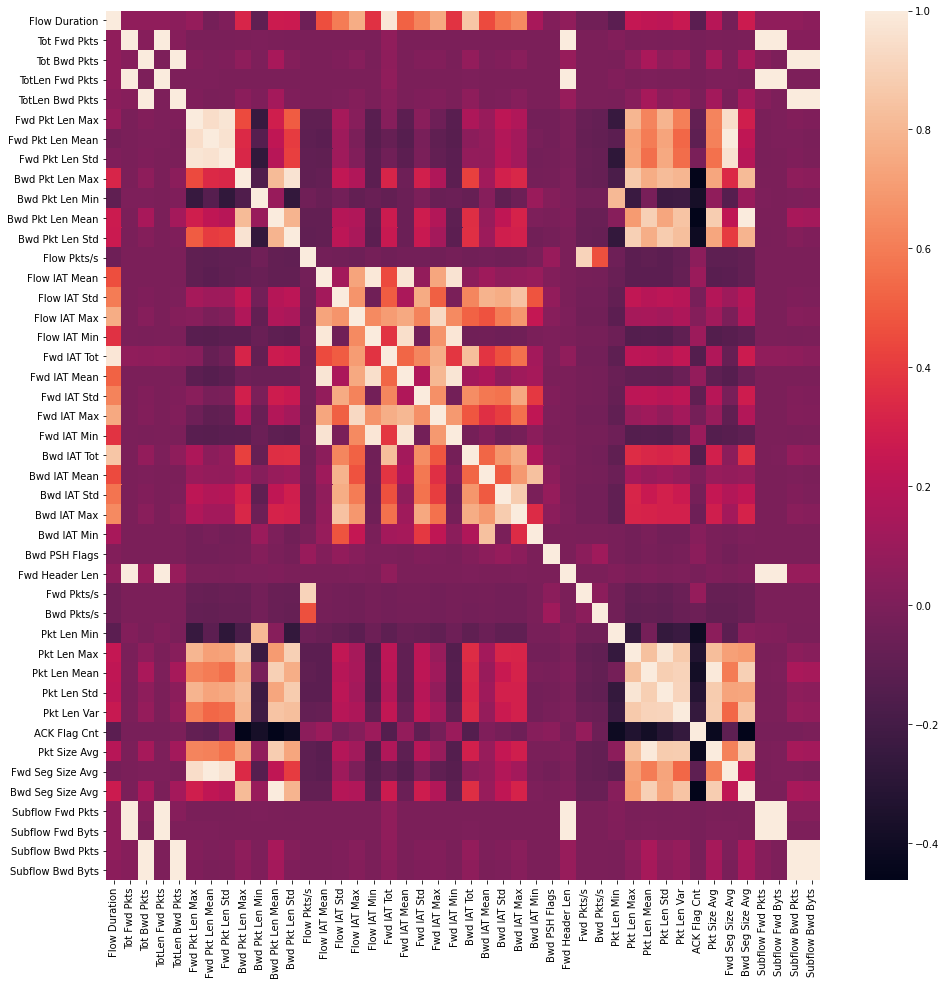

In [216]:
plt.figure(figsize=(16,16))
sns.heatmap(df3.corr())
plt.show()

In [161]:
df4 = df3[['Pkt Len Min', 'Bwd PSH Flags', 'Bwd Pkt Len Min', 
'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Flow IAT Mean', 'Fwd IAT Mean', 'Fwd IAT Min',
'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max',
'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'ACK Flag Cnt', 'Label']]

In [170]:
df3.columns

Index(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean',
       'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min',
       'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'ACK Flag Cnt', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Label'],
      dtype='object')

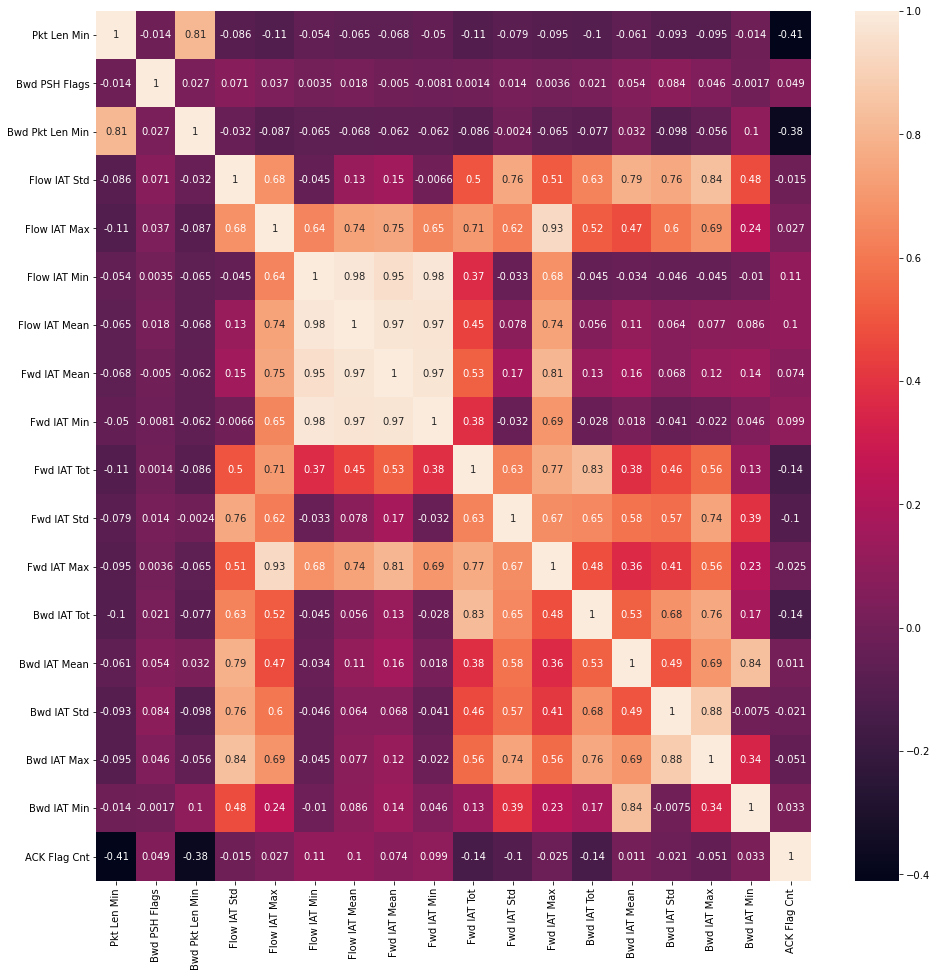

In [168]:
plt.figure(figsize=(16,16))
sns.heatmap(df4.corr(), annot=True)
plt.show()

In [269]:
df5 = df4[['Flow IAT Max', 'Flow IAT Std', 'Fwd IAT Tot', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Max', 'Bwd IAT Std', 'Label']].reset_index(drop=True)

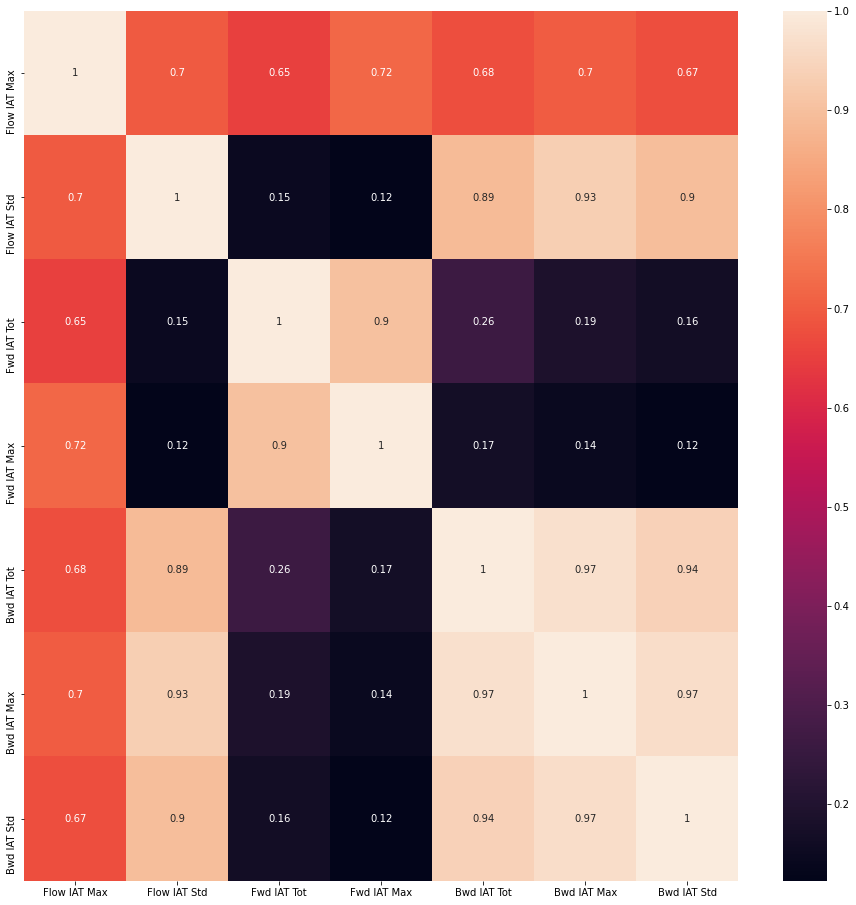

In [226]:
plt.figure(figsize=(16,16))
sns.heatmap(df5[df5['Label']=='ddos'].corr(), annot=True)
plt.show()

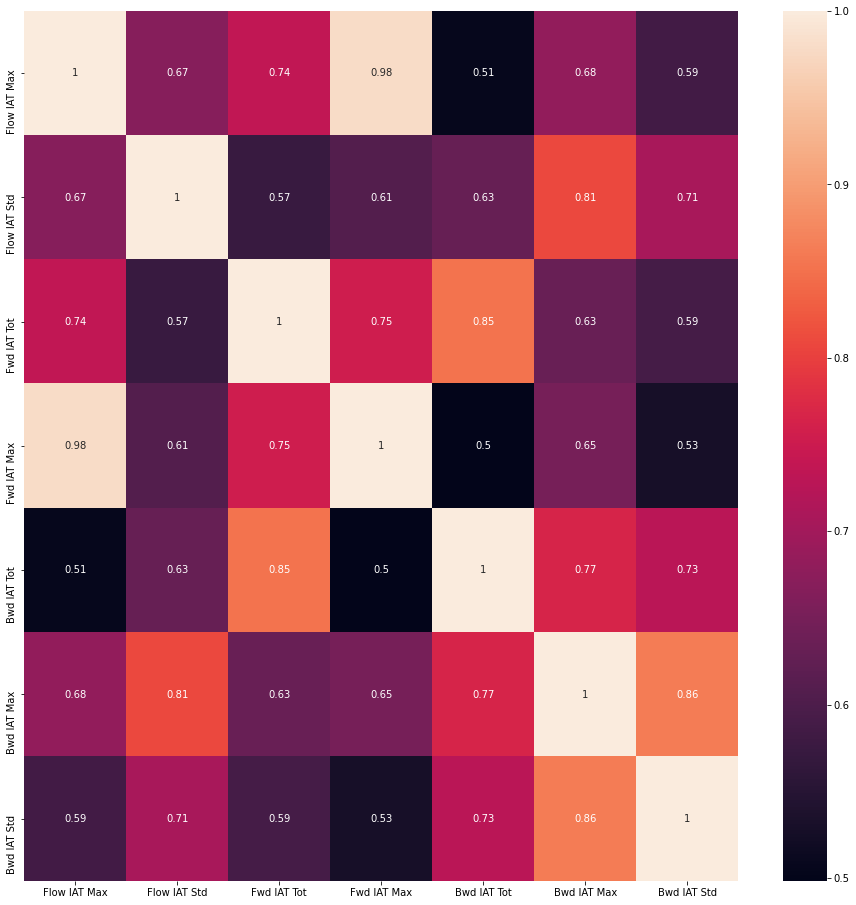

In [227]:
plt.figure(figsize=(16,16))
sns.heatmap(df5[df5['Label']=='Benign'].corr(), annot=True)
plt.show()

<Figure size 1152x1152 with 0 Axes>

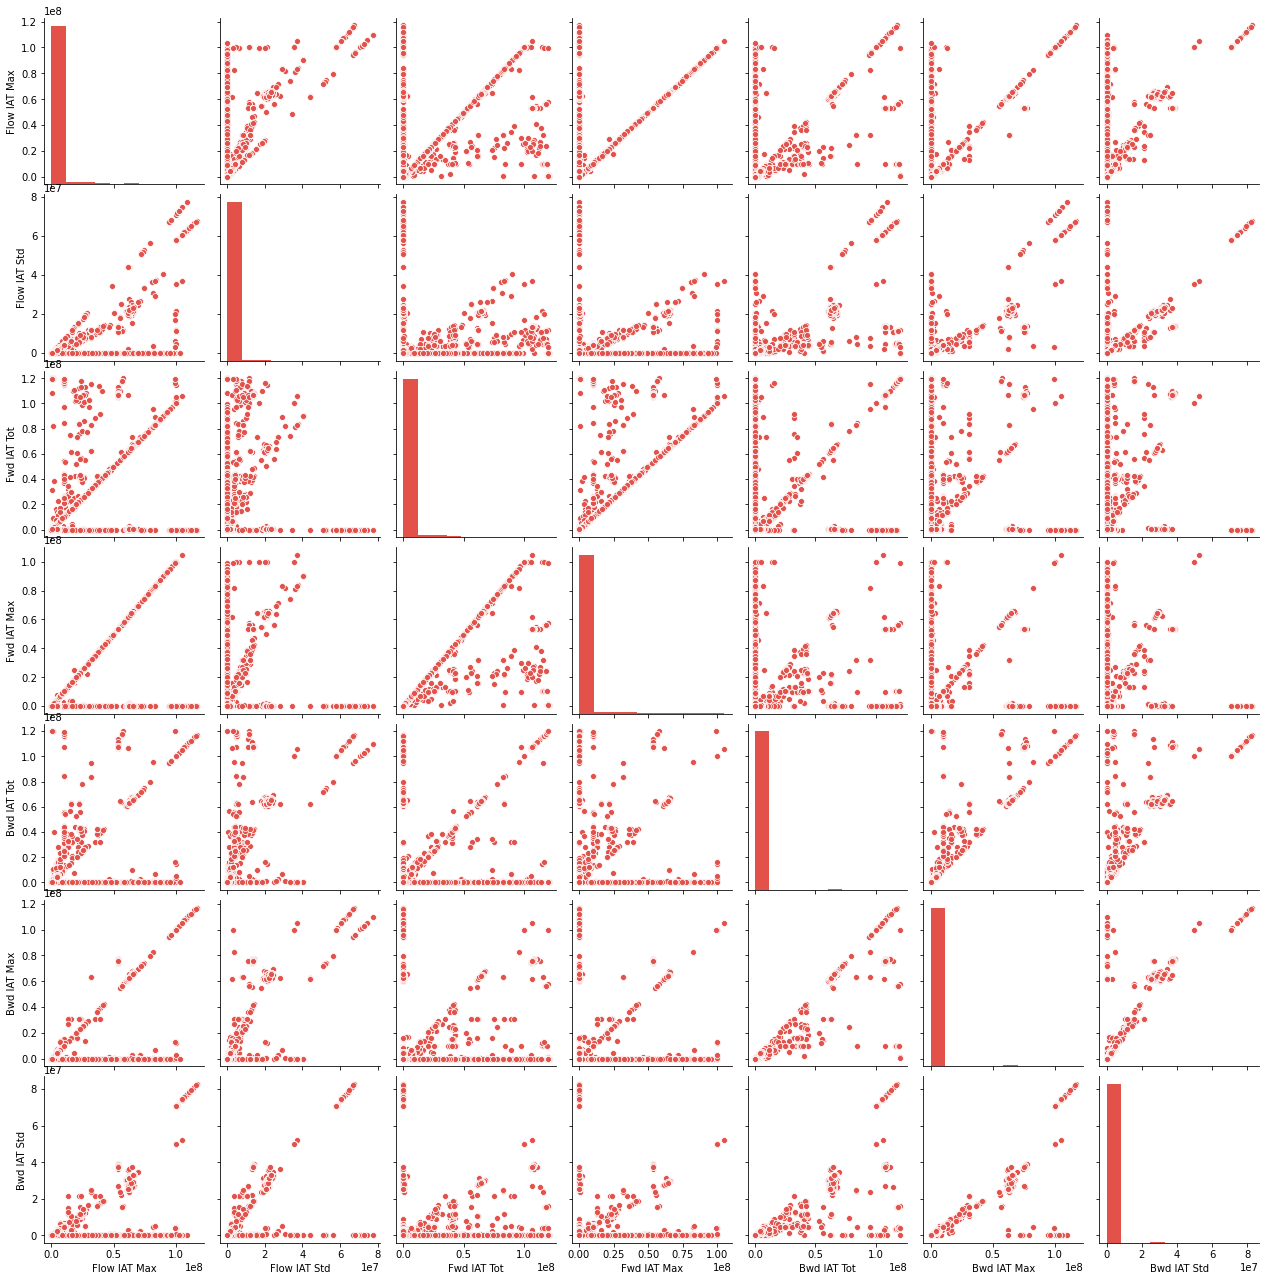

In [270]:
plt.figure(figsize=(16,16))
sns.pairplot(df5[df5['Label']=='ddos'])
plt.show()

<Figure size 1152x1152 with 0 Axes>

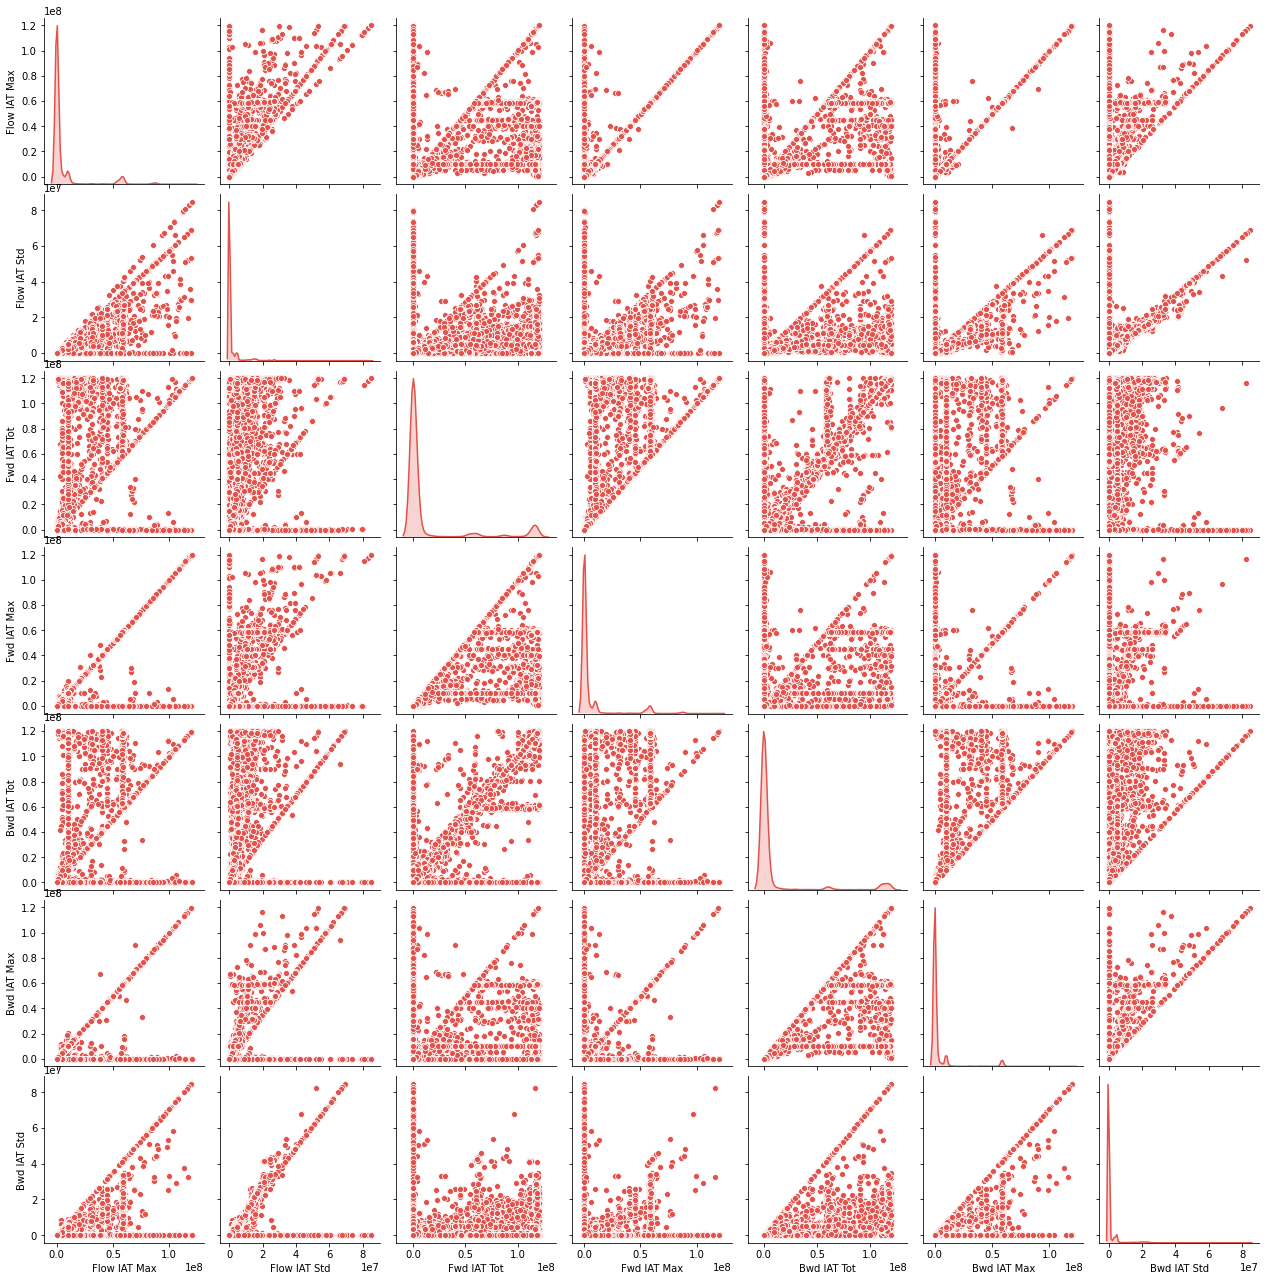

In [273]:
plt.figure(figsize=(16,16))
sns.pairplot(df5[df5['Label']=='Benign'], diag_kind='kde')
plt.show()

# Training

In [467]:
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from fcmeans import FCM
from sklearn.metrics import roc_curve

from mpl_toolkits.mplot3d import Axes3D

import graphviz 
from sklearn import tree

In [274]:
df5

,Flow IAT Max,Flow IAT Std,Fwd IAT Tot,Fwd IAT Max,Bwd IAT Tot,Bwd IAT Max,Bwd IAT Std,Label
0,3978389.0,1.497744e+06,97011.0,54875.0,4033267.0,3978389.0,2.281221e+06,ddos
1,41908.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,ddos
2,14052.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,ddos
3,3237488.0,1.218894e+06,76877.0,60571.0,3298065.0,3237488.0,1.851689e+06,ddos
4,92681.0,3.776267e+04,93594.0,92998.0,92998.0,92681.0,6.531121e+04,ddos
...,...,...,...,...,...,...,...,...
258299,10010237.0,4.969921e+06,45389692.0,10031059.0,40124019.0,10031088.0,1.198370e+02,Benign
258300,1223084.0,3.532656e+05,2711870.0,1223084.0,2591934.0,1281050.0,5.423767e+05,Benign
258301,140249.0,8.097164e+04,0.0,0.0,140253.0,140250.0,9.916960e+04,Benign
258302,56318626.0,4.030509e+01,112637195.0,56318626.0,0.0,0.0,0.000000e+00,Benign


In [389]:
def standardDevNormalization(array):
    result = []
    vstd = array.std()
    vmean = array.mean()
    
    for i, v_i in enumerate(array):
        result.append((v_i - vmean)/(2*vstd))
    return result

In [390]:
df6 = df5.loc[:, df5.columns != 'Label'].apply(standardDevNormalization)

In [231]:
df6.values

array([[-0.0147042 ,  0.07956408, -0.14499248, ..., -0.04211703,
         0.07133541,  0.16977413],
       [-0.16557596, -0.14000508, -0.14695976, ..., -0.1358634 ,
        -0.13726869, -0.14018898],
       [-0.16664359, -0.14000508, -0.14695976, ..., -0.1358634 ,
        -0.13726869, -0.14018898],
       ...,
       [-0.16180689, -0.12813464, -0.14695976, ..., -0.13260346,
        -0.12991478, -0.12671422],
       [ 1.99131685, -0.13999917,  2.13721038, ..., -0.1358634 ,
        -0.13726869, -0.14018898],
       [-0.16716958, -0.14000508, -0.14695976, ..., -0.1358634 ,
        -0.13726869, -0.14018898]])

In [321]:
df5.Label = df.Label.map({'ddos':0, 'Benign':1})

0

In [476]:
x = df6.values
y = df5.Label.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.90, random_state=42)

In [477]:
len(x_train)

25830

In [433]:
clf = tree.DecisionTreeClassifier()
# clf = clf.fit(x_train[100:1500], y_train[100:1500]) ## 0.87 f1-score
clf = clf.fit(x_train, y_train)

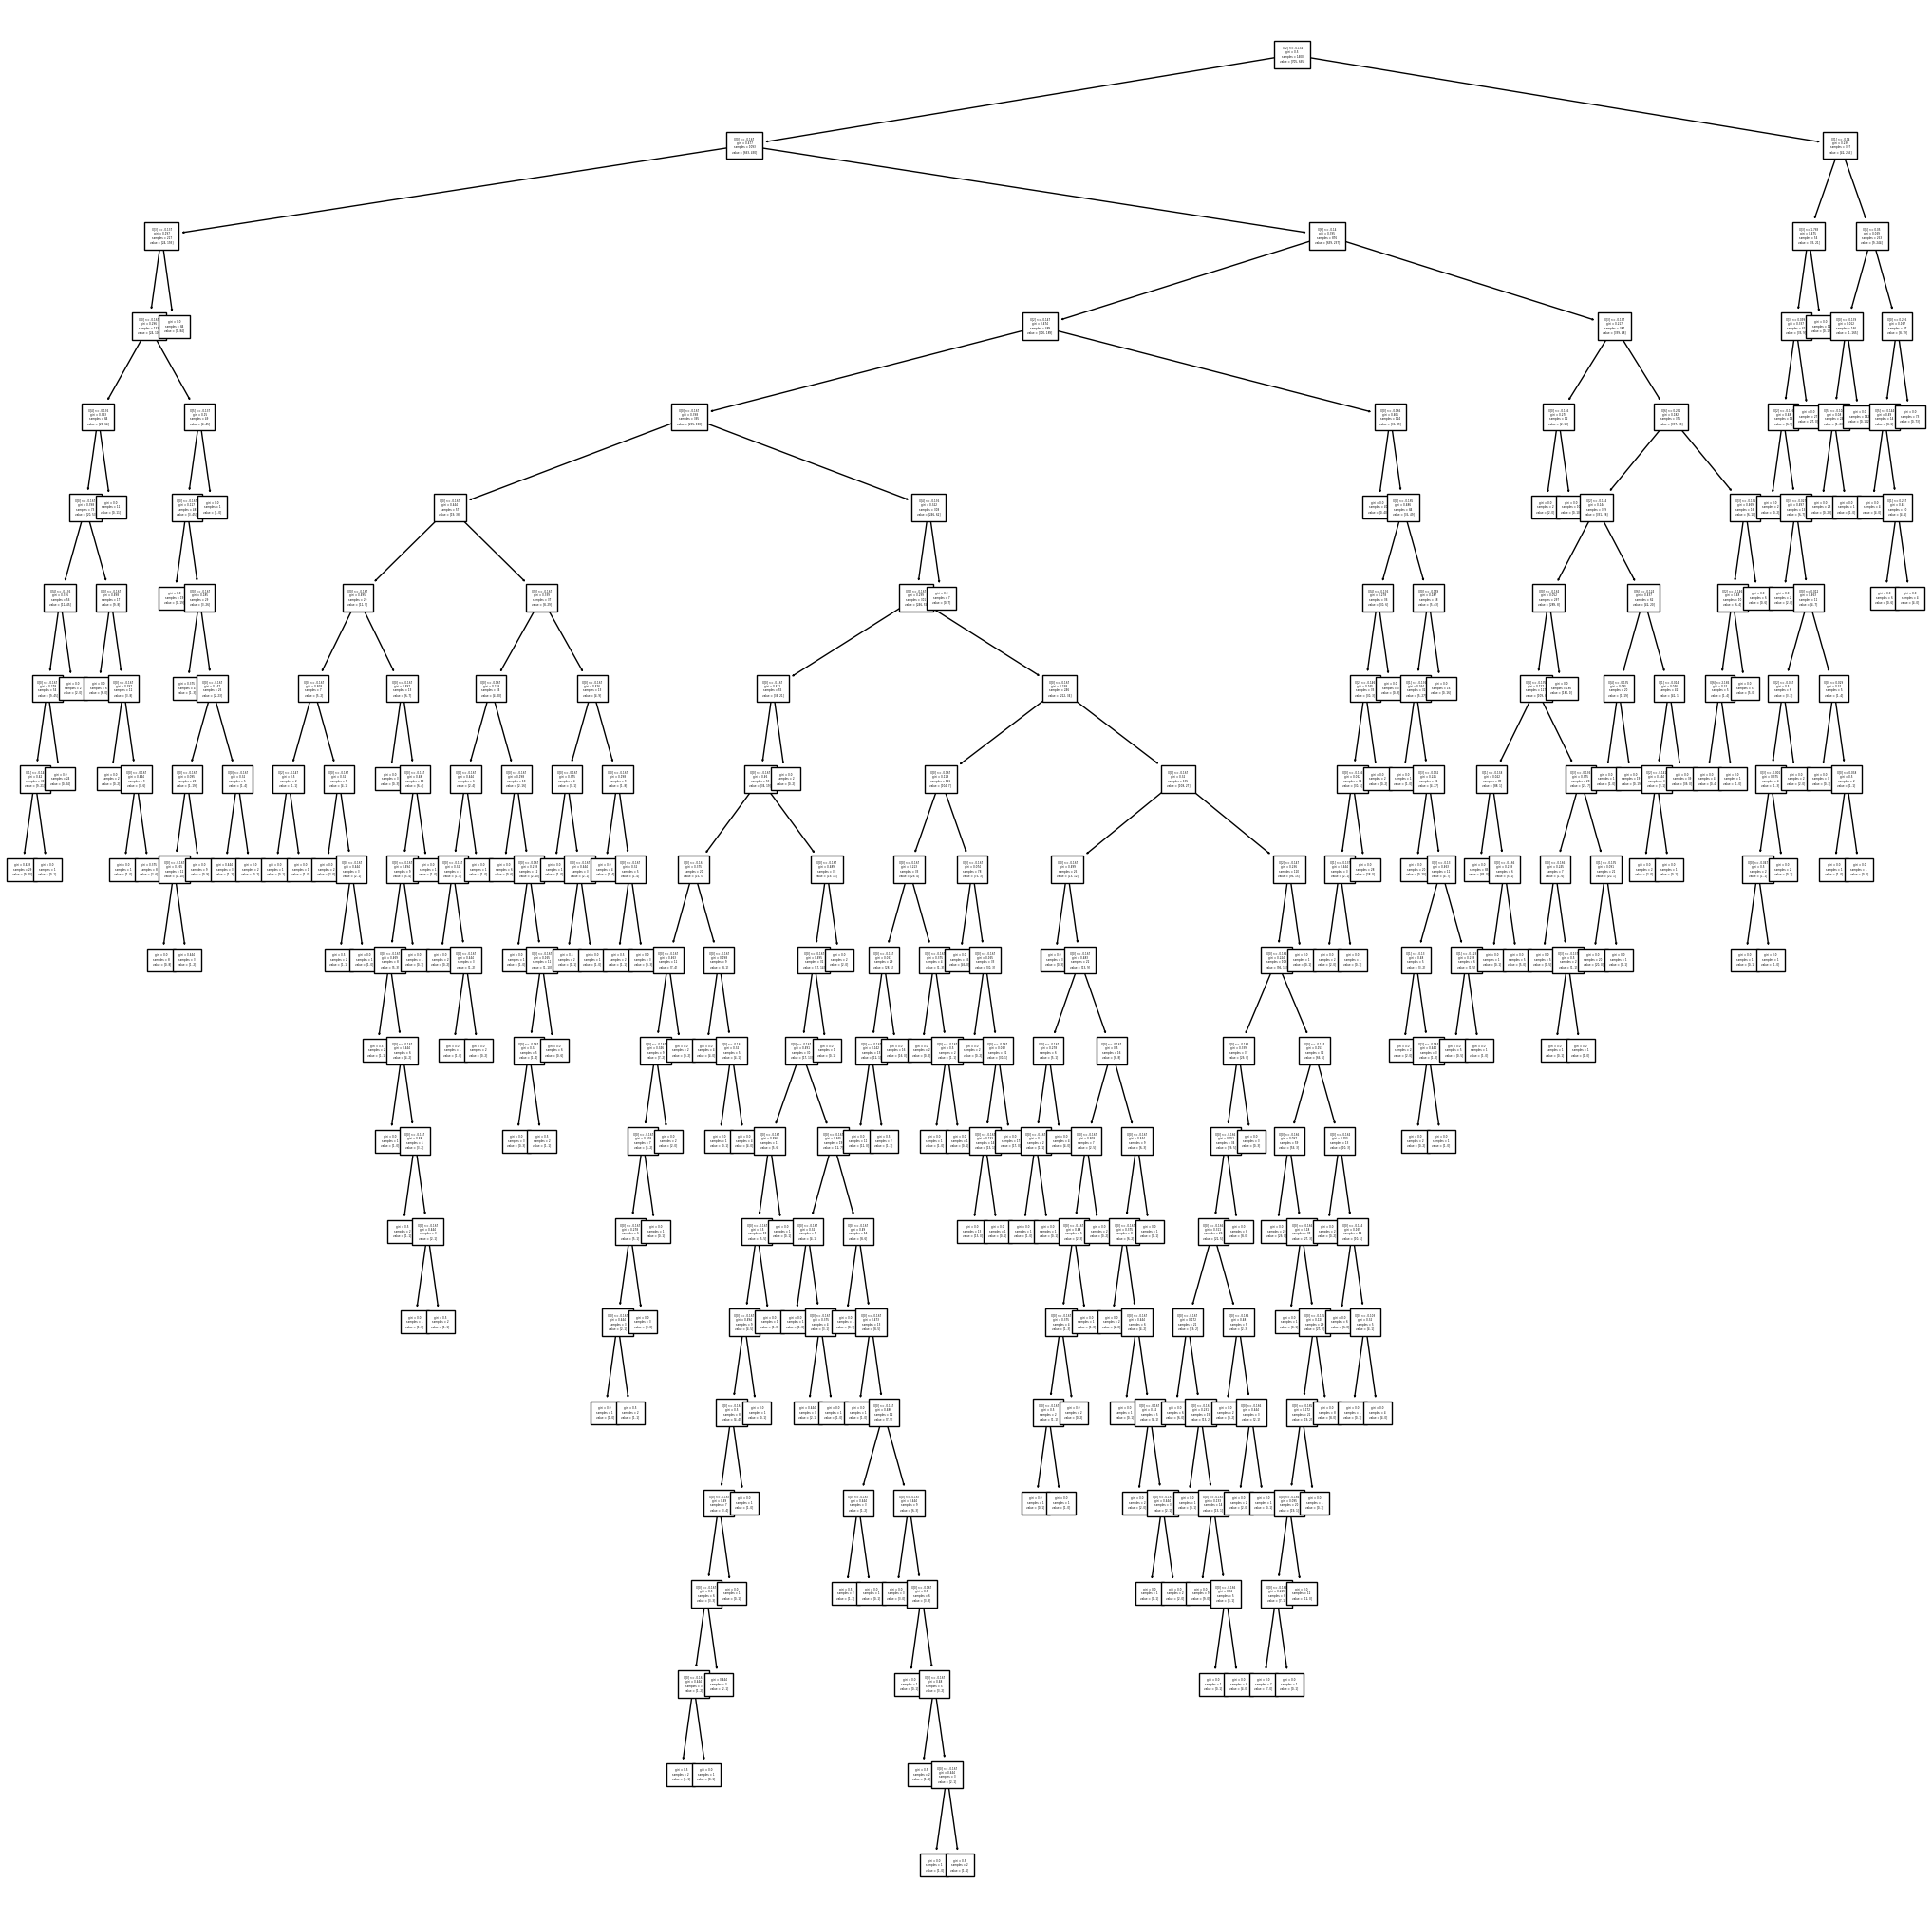

In [429]:
plt.figure(figsize=(26,26))
tree.plot_tree(clf, fontsize=2)
plt.show()

In [434]:
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89    116247
           1       0.89      0.91      0.90    116227

    accuracy                           0.89    232474
   macro avg       0.89      0.89      0.89    232474
weighted avg       0.89      0.89      0.89    232474



In [431]:
clf.get_n_leaves()

179

In [432]:
clf.get_depth()

20

[[102590  13657]
 [ 10931 105296]]


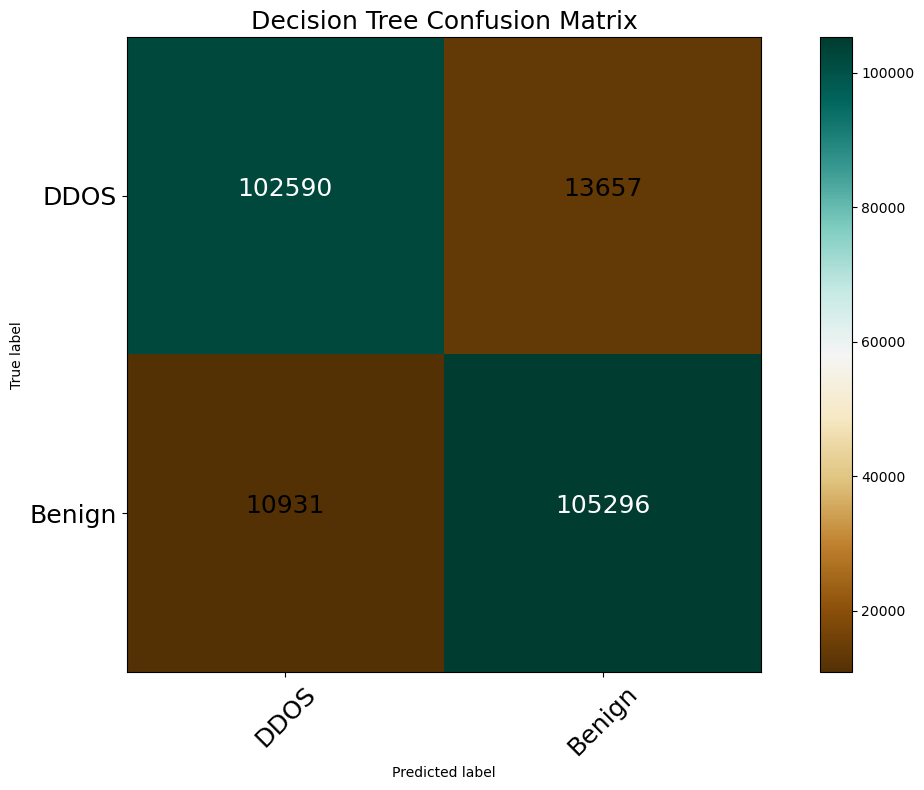

In [436]:
cmap=plt.cm.BrBG
labelS = [0, 1]
labelS2 = ['DDOS', 'Benign']
cm = confusion_matrix(y_test, y_pred, labels=labelS)
# if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
# else:
#     print('Confusion matrix, without normalization')

print(cm)
plt.figure(figsize=(12,8))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Decision Tree Confusion Matrix', fontsize=18 )
plt.colorbar()
tick_marks = np.arange(len(labelS2))
plt.xticks(tick_marks, labelS2, rotation=45, fontsize=18)
plt.yticks(tick_marks, labelS2, fontsize=18)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), fontsize=18,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

#  Testing

In [166]:
dftest = pd.read_csv("testing.csv")

In [246]:
dftest['TransactionID'] = dftest['Unnamed: 0'].astype(str)

In [248]:
dfout = dftest[['TransactionID']]

In [249]:
testing = dftest[list(df6.columns)]

In [250]:
testdata = testing.apply(standardDevNormalization)

In [252]:
res = clf.predict(testdata)

In [253]:
dfout['isFraud'] = res

In [254]:
dfout.isFraud = dfout.isFraud.map({0:'ddos', 1:'Benign'})
dfout.isFraud = dfout.isFraud.map({'ddos':1, 'Benign':0})

In [ ]:
dfout.len

In [2]:
dfout.to_csv('TestDatasetForCompetitionResults_Michael_Telahun.csv')

NameError: name 'dfout' is not defined